In [1]:
%reset -f -s
%matplotlib inline
'''------------------------------------------------------------------
MA-eR-PINN: eRange Prediction using Physics-Informed Neural Networks
---------------------------------------------------------------------
Version: V2.1      Modified: 15.01.2025        William Siegle
---------------------------------------------------------------------
PTRAIN - Standard Pipeline Framework for Training the PINN
+ OPTUNA - Hyperparameter Optimization using Optuna
------------------------------------------------------------------''';

In [2]:
# MA-eR-PINN: CONFIGURATION FILE -------------------------------------------------
from pathlib import Path
CONFIG = {
    # SYSTEM: ---------------------------------------------------------------------
    "GPU_SELECT":       0,
    "ROOT":             Path('../..').resolve(),
    "INPUT_LOCATION":   Path("TripSequences", "trips_processed_pinn_2"), 
    "OUTPUT_LOCATION":  Path("src", "models", "pth"),
    "SEED"  :           20,
    "MIXED_PRECISION":  True,

    # DATA PREPROCESSING: ---------------------------------------------------------
    "TRAIN_VAL_TEST":   [0.8, 0.1, 0.1], # [train, val, test splits]
    "MAX_FILES":        None, # None: all files
    "MIN_SEQ_LENGTH":   3600, # minimum sequence length in s to be included in DataSets
    "SCALERS":          {'feature_scaler': 'MinMaxScaler()','target_scaler': 'MinMaxScaler()','prior_scaler': 'MinMaxScaler()'},

    # FEATURES: -------------------------------------------------------------------
    "FEATURES":         ['accelpdlposn_cval','actdrvtrnpwrprc_cval','actualdcvoltage_pti1','actualspeed_pti1','actualtorque_pti1',
                        'airtempinsd_cval_hvac','airtempinsd_rq','airtempoutsd_cval_cpc','altitude_cval_ippc','brc_stat_brc1','brktempra_cval',
                        'bs_brk_cval','currpwr_contendrnbrkresist_cval','elcomp_pwrcons_cval','epto_pwr_cval','hv_bat_dc_momvolt_cval_bms1',
                        'hv_batavcelltemp_cval_bms1','hv_batcurr_cval_bms1','hv_batisores_cval_e2e','hv_batmaxchrgpwrlim_cval_1',
                        'hv_batmaxdischrgpwrlim_cval_1','hv_curr_cval_dcl1','hv_dclink_volt_cval_dcl1','hv_ptc_cabin1_pwr_cval','hv_pwr_cval_dcl1',
                        'lv_convpwr_cval_dcl1','maxrecuppwrprc_cval','maxtracpwrpct_cval','motortemperature_pti1','powerstagetemperature_pti1',
                        'rmsmotorcurrent_pti1','roadgrad_cval_pt','selgr_rq_pt','start_soc','txoiltemp_cval_tcm','vehspd_cval_cpc','vehweight_cval_pt'],                 
    "TARGETS":          ['hv_bat_soc_cval_bms1'],
    "PRIORS":           ['emot_soc_pred'],  

    # MODEL: -----------------------------------------------------------------------
    "HIDDEN_SIZE":      100,    # features in the hidden state h
    "NUM_LAYERS":       2,      # recurrent layers for stacked LSTMs. Default: 1
    "DROPOUT":          0.3,   # usually: [0.2 - 0.5]
    
    # TRAINING & OPTIMIZER: --------------------------------------------------------
    "NUM_EPOCHS":       30,
    "BATCH_SIZE":       256,         # [2, 4, 8, 16, 32, 64, 128, 256]
    "LEARNING_RATE":    0.001,       # 0.001 lr
    "WEIGHT_DECAY":     0.001,       # weight decay coefficient (default: 1e-2)
    "MOMENTUM_SGD":     0.1,        # (default: 0.0)
    "OPTIMIZER":        'adamw',    # ('adam', 'sgd', 'adamw')
    "WEIGHT_INIT_TYPE": 'he',  # ('he', 'normal', 'default')
    "CLIP_GRAD":        2.0,        # default: None
    "LRSCHEDULER":      "torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)",  # constant LR for 1.0 as multiplicative factor

    # LOSS FUNCTION: ---------------------------------------------------------------
    "CRITERION":        "nn.SmoothL1Loss()", # ['nn.MSELoss()', 'nn.L1Loss()', 'nn.SmoothL1Loss()', 'nn.HuberLoss()', 'MASE()']
    "P_LOSS_FACTOR":    0.5, # Physics loss factor
}

In [3]:
# TBD: CHECK IF L_P IS ADJUSTED CORRECTLY BY FUNCTION CALLABLE !!!!
# LOSS FUNCTION MODULES ----------------------------------------------------------------   

def loss_fn_PINN_3(output, target, prior):
    l_p = P_LOSS_FACTOR
    y_pred = output; y_true = target; y_phys = prior
    total_loss = F.mse_loss(y_true, (l_p * y_phys + (1 - l_p) * y_pred), reduction='mean')
    return total_loss

global LOSS_FN
LOSS_FN = loss_fn_PINN_3


___
SETUP: Locate devices & system folders

In [4]:
# LOCATE REPOSITORY/DATASTORAGE IN CURRENT SYSTEM ENVIRONMENT  ---------------------------
import sys, os
for key in CONFIG: globals()[key] = CONFIG[key]
if 'ROOT' not in globals(): ROOT = Path('../..').resolve()
sys.path.append(os.path.abspath(ROOT)); print(ROOT)

# INTERNAL MODULE IMPORTS ----------------------------------------------------------------
from src.__init__ import *
from src.utils.data_utils import *
from src.utils.preprocess_utils import *
from src.utils.eval_utils import *
from src.utils.Trainers import *
from src.models.lstm_models import *

# SETUP ENVIRONMENT ---------------------------------------------------------------------
DATA_PATH, IS_NOTEBOOK, DEVICE, LOG_FILE_NAME, TS = setup_environment(CONFIG, ROOT, SEED, GPU_SELECT)
if not IS_NOTEBOOK: output_file = open(f"{LOG_FILE_NAME}", "w"); sys.stdout = Tee(sys.stdout, output_file); sys.stderr = Tee(sys.stderr, output_file)

# FILE SOURCES ---------------------------------------------------------------
input_folder = Path(DATA_PATH, INPUT_LOCATION) # Trip parquet files
pth_folder = Path(ROOT, OUTPUT_LOCATION, f"{TS}")
pth_folder.mkdir(parents=True, exist_ok=True)
files, trip_lengths, indices_by_length, sorted_trip_lengths, all_signals = prepare_data(input_folder, pth_folder, MAX_FILES, MIN_SEQ_LENGTH, ROOT)

/home/sieglew/MA-eR-PINN
------------------------------------------------------------
Directories:
  /home/sieglew/MA-eR-PINN:			test, .git, archive, project, data, src
  /mnt/nvme/datasets/sieglew:			TripSequences
------------------------------------------------------------
Running in notebook mode
CONFIG Dictionary:
---------------------------------------------------------------------------------------------------------------------------------
     Parameter         Value
--  ----------------  ---------------------------------------------------------------------------------------------------------
0   GPU_SELECT        0
1   ROOT              /home/sieglew/MA-eR-PINN
2   INPUT_LOCATION    TripSequences/trips_processed_pinn_2
3   OUTPUT_LOCATION   src/models/pth
4   SEED              20
5   MIXED_PRECISION   True
6   TRAIN_VAL_TEST    [0.8, 0.1, 0.1]
7   MAX_FILES         None
8   MIN_SEQ_LENGTH    3600
9   SCALERS           {'feature_scaler': 'MinMaxScaler()', 'target_scaler': 'MinMa

___
DATA SELECTION & PREPROCESSING

In [5]:
# FEATURE SELECTION & SCALING ----------------------------------------------------------------------------
INPUT_COLUMNS = FEATURES; TARGET_COLUMN = TARGETS; PRIOR_COLUMN = PRIORS
print(f"{'-'*60}\nInput Signals:\t{len(FEATURES)}\nTarget Signals:\t{len(TARGETS)}\nPhysical Prior Signals:\t{len(PRIORS)}\n{'-'*60}")
scaler, target_scaler, prior_scaler = eval(SCALERS['feature_scaler']), eval(SCALERS['target_scaler']), eval(SCALERS['prior_scaler'])

# DATA SET SPLITTING AND SORTING ----------------------------------------------------------------
train_subset, val_subset, test_subset = random_split(files, TRAIN_VAL_TEST)

# DATALOADER SETTINGS ------------------------------------------------------------------
dataloader_settings = {'batch_size': 1, 'shuffle': True, 'collate_fn': collate_fn_PINN, 'num_workers': 8,
 'prefetch_factor': 4, 'persistent_workers': True, 'pin_memory': False if DEVICE.type == 'cpu' else True}

# PREPARE TRAIN, VAL & TEST DATALOADERS  ------------------------------------------------------------
train_subset, train_dataset, train_dataset_batches, train_loader = prepare_dataloader_PINN(train_subset, indices_by_length, \
    BATCH_SIZE, INPUT_COLUMNS, TARGET_COLUMN, PRIOR_COLUMN, scaler, target_scaler, prior_scaler, dataloader_settings, fit=True, drop_last=True)

val_subset, val_dataset, val_dataset_batches, val_loader = prepare_dataloader_PINN(val_subset, indices_by_length, \
    BATCH_SIZE, INPUT_COLUMNS, TARGET_COLUMN, PRIOR_COLUMN, scaler, target_scaler, prior_scaler, dataloader_settings, drop_last=False)

test_subset, test_dataset, test_dataset_batches, test_loader = prepare_dataloader_PINN(test_subset, indices_by_length, \
    BATCH_SIZE, INPUT_COLUMNS, TARGET_COLUMN, PRIOR_COLUMN, scaler, target_scaler, prior_scaler, dataloader_settings, drop_last=False)

# print dataset info
subset_files = print_dataset_sizes(train_dataset, val_dataset, test_dataset, train_subset, val_subset, test_subset, files)

# -----------------------------------------------------------------------------------
# Load dataloaders instead
#train_loader = torch.load('train_loader.pth')
#val_loader = torch.load('val_loader.pth')
#test_loader = torch.load('test_loader.pth')

# optional visualizations of padding preprocessing:
if IS_NOTEBOOK and False: 
    check_batch_PINN(train_loader)
    visualize_padding(BATCH_SIZE, trip_lengths, sorted_trip_lengths, train_loader, val_loader, test_loader)

------------------------------------------------------------
Input Signals:	37
Target Signals:	1
Physical Prior Signals:	1
------------------------------------------------------------


 --> Warning: Removed the last 161 samples to ensure a balanced batch size
fitting Scalers: MinMaxScaler, MinMaxScaler, MinMaxScaler
	50% of the fitting done...
Done. Create DataSets and DataLoaders...
	Number of batches created: 11
	Number of batches created: 2
	Number of batches created: 2
------------------------------------------------------------
Train size:  21073533		(Files: 2816)
Val. size:   2641629		(Files: 372)
Test size:   2678763		(Files: 372) 
 ------------------------------------------------------------
	Removed 161 file from the dataset
------------------------------------------------------------


___
MODEL & TRAINING CONFIGURATIONS

In [6]:
# LSTM NETWORK -----------------------------------------------------------------------

class LSTM1_packed_old_version(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, device=DEVICE):
        super(LSTM1_packed_old_version, self).__init__()

        self.input_size = input_size    # input size
        self.hidden_size = hidden_size  # hidden state
        self.num_layers = num_layers    # number of layers
        self.dropout = dropout

        # LSTM CELL --------------------------------
        self.lstm = nn.LSTM(self.input_size,self.hidden_size,self.num_layers,batch_first=True,dropout=self.dropout,device=device)

        # LAYERS -----------------------------------
        self.dropout_layer = nn.Dropout(self.dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn1 = nn.BatchNorm1d(hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, 1)
        self.relu = nn.ReLU()

    def forward(self, packed_input, batch_size=None):
        packed_out, _ = self.lstm(packed_input)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)
        out = self.relu(out)  # relu
        out = self.dropout_layer(out)  # dropout
        out = self.fc1(out)  # fully connected layer 1
        out = self.bn1(out.transpose(1, 2)).transpose(1, 2)
        out = self.relu(out)  # relu
        out = self.fc2(out)  # fully connected layer 2
        return out

    # Define the weight initialization function for LSTM
    def initialize_weights_lstm(self, init_type):
        for name, param in self.named_parameters():
            if 'weight_ih' in name or 'weight_hh' in name:
                if init_type == 'he': nn.init.kaiming_uniform_(param.data, nonlinearity='relu')     # HE INIT
                elif init_type == 'normal': nn.init.normal_(param.data, mean=0.0, std=0.02)         # NORMAL INIT
                elif init_type == 'default': continue                                               # TORCH DEFAULT INIT
            elif 'bias' in name and init_type != 'default': nn.init.constant_(param.data, 0)

___
TRAINING

------------------------------------------------------------
Training Started.	Process ID: 2335479 
------------------------------------------------------------
Model: LSTM1_packed_old_version	Parameters on device: CUDA:0
------------------------------------------------------------
Train/Batch size:	11 / 11
Loss:			<function loss_fn_PINN_3 at 0x7f1b57c82700>
Optimizer:		AdamW
LR:			0.001
Weight Decay:		0.001
------------------------------------------------------------


Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

------------------------------------------------------------
Training Completed.	Execution Time: 00:05:31
------------------------------------------------------------



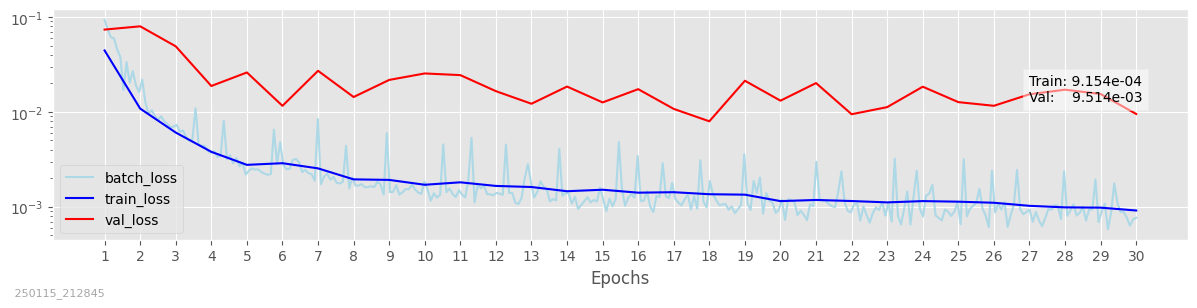

In [7]:
# INSTANTIATE MODEL --------------------
model = LSTM1_packed_old_version(len(INPUT_COLUMNS), HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(DEVICE)
model.initialize_weights_lstm(WEIGHT_INIT_TYPE)
#print_info(model)

# SET OPTIMIIZER, SCHEDULER AND LOSS MODULES ---------------------------
if OPTIMIZER=='adam': optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
elif OPTIMIZER=='adamw': optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
elif OPTIMIZER=='sgd': optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM_SGD, weight_decay=WEIGHT_DECAY)

def lr_lambda(epoch): return 1.0
scheduler = eval(LRSCHEDULER); criterion = eval(CRITERION)

# TRAIN -----------------------------------------------------------------
TRAINER = PTrainer_PINN(
    model = model, 
    optimizer = optimizer, 
    scheduler = scheduler,
    loss_fn = LOSS_FN, 
    train_loader = train_loader, 
    val_loader = val_loader, 
    test_loader = test_loader, 
    num_epochs = NUM_EPOCHS, 
    device = DEVICE, 
    is_notebook = IS_NOTEBOOK, 
    use_mixed_precision = MIXED_PRECISION, 
    clip_value = CLIP_GRAD, 
    log_file = Path(LOG_FILE_NAME).with_name(f"{TS}_log.txt"))

RESULTS = TRAINER.train_model()

# PLOT RESULTS AND SAVE OPERATIONS ----------------------------------------------
plot_training_performance(RESULTS)

___
SAVE CHECKPOINT

In [8]:
# SAVE MODEL -----------------------------------------------------------------
CHECKPOINT, model_destination_path = save_checkpoint(TRAINER, train_loader, val_loader, test_loader, RESULTS, CONFIG, subset_files, pth_folder, TS)

Model saved to:	 LSTM1_packed_old_version_250115_212845.pt
------------------------------------------------------------
Model ID: LSTM1_packed_old_version_250115_212845
------------------------------------------------------------
Size: 1.87 MB
------------------------------------------------------------
log_file: /home/sieglew/MA-eR-PINN/src/models/log/250115_212845/250115_212845_log.txt


___
LOAD CHECKPOINT

In [9]:
# model_destination_path = Path(pth_folder, "LSTM1_packed_old_version_241216_082030.pth")

In [10]:
# LOAD MODEL -----------------------------------------------------------------
CHECKPOINT = load_checkpoint(model_destination_path, DEVICE)
for key in CHECKPOINT.keys(): globals()[key] = CHECKPOINT[key]
# load model and optimizer states --------------------------------------------
model.load_state_dict(model_state_dict)
optimizer.load_state_dict(optimizer_state_dict)
model.eval()  # set model to evaluation mode for inference

Model loaded from:	/home/sieglew/MA-eR-PINN/src/models/pth/250115_212845/LSTM1_packed_old_version_250115_212845.pt
------------------------------------------------------------
Model: LSTM1_packed_old_version	Parameters on device: cuda:0
------------------------------------------------------------
Train/Batch size:	11 / 256
Loss:			<function loss_fn_PINN_3 at 0x7f1b57c82700>
Optimizer:		AdamW
LR:			0.001
Weight Decay:		0.001
------------------------------------------------------------



LSTM1_packed_old_version(
  (lstm): LSTM(37, 100, num_layers=2, batch_first=True, dropout=0.3)
  (dropout_layer): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=100, out_features=50, bias=True)
  (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)

___
EVALUATION

In [11]:
# EVALUATION -----------------------------------------------------------------
# get file list of test subset
test_files = CHECKPOINT["test_files"]; print(f"{'-'*60}\nTest subset: {len(test_files)} files\n{'-'*60}")
# -------------------------------------
# evaluate model on test set
test_loss, all_outputs, all_targets, all_priors, all_original_lengths = TRAINER.evaluate_model()
# -------------------------------------
# Inverse-transform on all outputs and targets for evaluation
scaled_outputs = [target_scaler.inverse_transform(output_sequence.reshape(1, -1)).squeeze() for output_sequence in all_outputs]
scaled_targets = [target_scaler.inverse_transform(target_sequence.reshape(1, -1)).squeeze() for target_sequence in all_targets]
scaled_priors = [prior_scaler.inverse_transform(prior_sequence.reshape(1, -1)).squeeze() for prior_sequence in all_priors]

# concatenate:
all_y_true, all_y_pred, all_y_phys = np.concatenate(scaled_targets), np.concatenate(scaled_outputs), np.concatenate(scaled_priors)

# calculate evaluation metrics
print(f"Test Loss:\t\t{test_loss:.6f}")
metrics = calculate_metrics(all_y_true, all_y_pred) # [rmse, mae, std_dev, mape, r2, max_error]
print("Metrics (unweighted):")
mean_metrics = calculate_metrics_per_sequence(scaled_targets, scaled_outputs)

------------------------------------------------------------
Test subset: 372 files
------------------------------------------------------------
Test Loss:		0.009124
RMSE:			17.9583        
MAE ± STD (MAPE):	16.4730 ± 7.4083 (28.92%)
R-squared:		0.3101
------------------------------------------------------------
Metrics (unweighted):
RMSE:			17.5748        
MAE ± STD (MAPE):	16.7516 ± 4.1824 (29.80%)
R-squared:		-16.9372
------------------------------------------------------------


___
PLOT RESULTS

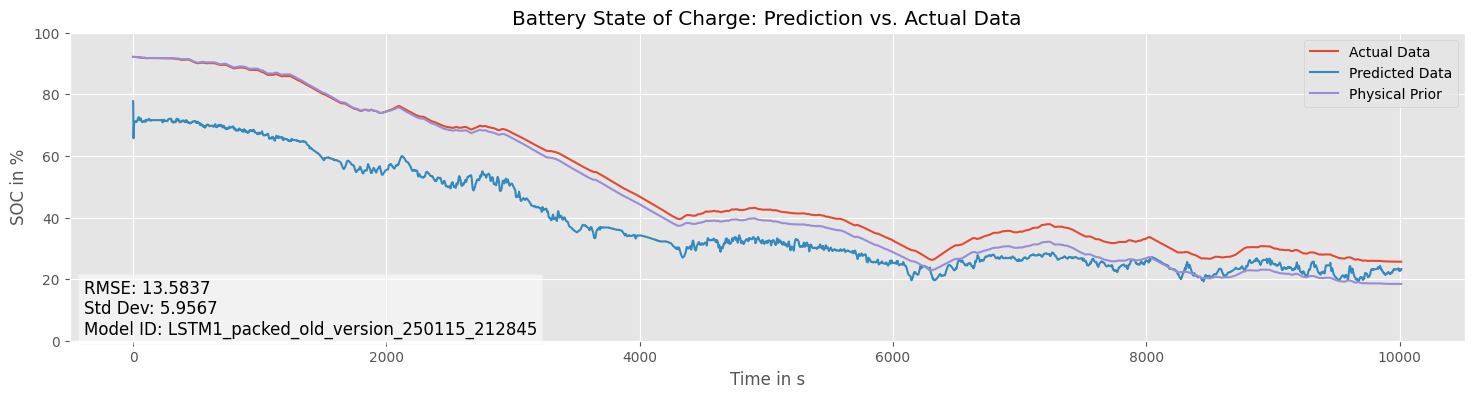

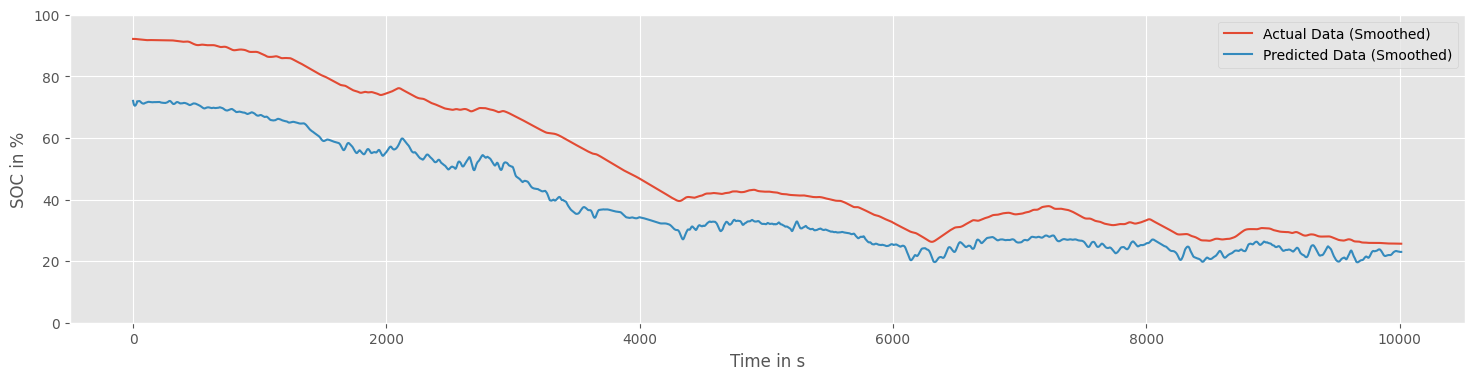

In [12]:
# get random sample sequence from test set
sample_int = random.randint(1, len(test_files)-1)
y_true, y_pred, y_phys = scaled_targets[sample_int], scaled_outputs[sample_int], scaled_priors[sample_int]

# ----------->  add specific file selector for easier comparison
###############################################
# PLOT PREDICTION -----------------------------------------------------------------

plt.figure(figsize=(18,4)); plt.xlabel('Time in s'); plt.ylabel('SOC in %'); plt.title('Battery State of Charge: Prediction vs. Actual Data') 
plt.plot(y_true, label='Actual Data') # actual plot
plt.plot(np.arange(0, len(y_true), 1), y_pred, label='Predicted Data') # predicted plot
plt.plot(y_phys, label='Physical Prior') # physical prior
plt.ylim(0, 100) # set y-axis limits

plt.legend()
plt.text(0.01, 0.02, f"RMSE: {root_mean_squared_error(y_true, y_pred):.4f}\nStd Dev: {np.std(y_true - y_pred):.4f}\nModel ID: {model_name_id}",\
     transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.figure(figsize=(18,4)); plt.xlabel('Time in s'); plt.ylabel('SOC in %')
plt.plot(savgol_filter(y_true.flatten(), window_length=60, polyorder=3), label='Actual Data (Smoothed)') # actual plot
plt.plot(np.arange(0, len(y_true), 1), savgol_filter(y_pred.flatten(), window_length=60, polyorder=3), label='Predicted Data (Smoothed)') # predicted plot
plt.ylim(0, 100) # set y-axis limits
plt.legend();

In [13]:
if not IS_NOTEBOOK: sys.stdout.close(); sys.stderr.close()